#### Wiktor Głazek ####
## Szczyt państw z grupy G7 w Hiroszimie, 19 - 21 maja 2023 ##
### Analiza tweetów z wykorzystaniem technik przetwarzania tekstu (wersja SMALL, ok 3000 tweetów) ###

### Wstęp ###

Tematem pracy jest analiza tweetów dotyczących szczytu państw z grupy G7 w Hiroszimie.
Za powiązane z tematem uznaje się tweety z hashtagami: #G7, #G7HiroshimaSummit, #G7Summit, #G7Hiroshima. Tweety zostały pozyskane z wykorzystaniem biblioteki snscrape dla trzech przedziałów czasu:
 - przed obradami szczytu G7: 01.01.2023 -> 18.05.2023
 - w trakcie obrad szczytu G7: 19.05.2023 -> 21.05.2023
 - po obradach szczytu G7: od 21.05.2023

### Web scraping tweetów z wykorzystaniem biblioteki snscrape ###

In [1]:
import snscrape.modules.twitter as sntwitter
import nest_asyncio
import pandas as pd

In [2]:
TWEETS_NUMBER = 10000
SCRAPER_ACTIVE = False

if SCRAPER_ACTIVE:
    nest_asyncio.apply()
    tweets_before_summit = []
    tweets_during_summit = []
    tweets_after_summit = []

    for i,tweet in enumerate(sntwitter.TwitterSearchScraper('(#G7 OR #G7HiroshimaSummit OR #G7Summit OR #G7Hiroshima) lang:en since:2023-01-01 until:2023-05-19').get_items()):
        if i==TWEETS_NUMBER-1:
            break
        tweets_before_summit.append([tweet.date, tweet.rawContent])
    print("scraper1 ready")

    for i,tweet in enumerate(sntwitter.TwitterSearchScraper('(#G7 OR #G7HiroshimaSummit OR #G7Summit OR #G7Hiroshima) lang:en since:2023-05-19 until:2023-05-22').get_items()):
        if i==TWEETS_NUMBER-1:
            break
        tweets_during_summit.append([tweet.date, tweet.rawContent])
    print("scraper2 ready")

    for i,tweet in enumerate(sntwitter.TwitterSearchScraper('(#G7 OR #G7HiroshimaSummit OR #G7Summit OR #G7Hiroshima) lang:en since:2023-05-22').get_items()):
        if i==TWEETS_NUMBER-1:
            break
        tweets_after_summit.append([tweet.date, tweet.rawContent])
    print("scraper3 ready")

    df1 = pd.DataFrame(data = tweets_before_summit, columns=["Date", "Content"])
    df2 = pd.DataFrame(data = tweets_during_summit, columns=["Date", "Content"])
    df3 = pd.DataFrame(data = tweets_after_summit, columns=["Date", "Content"])

    df1.to_csv("data_set_big_1.csv")
    df2.to_csv("data_set_big_2.csv")
    df3.to_csv("data_set_big_3.csv")

### Preprocessing bazy danych ###

Treść tekstu każdego z tweetów została poddana preprocessingu.
Z tekstu zostały usunięte stopwords a następnie wyodrębniono tokeny które zlematyzowano metodą WordNetLemmatizer. Dodatkowo, usunięto błędy oraz słowa o niskiej wartości przy analizie, takie jak popularne czasowaniki i typowe rzeczowniki związane z "kulturą" dyplomatyczno-polityczną.

#### Tokenizacja, usuwanie stopwords, lematyzacja ####

In [3]:
df1 = pd.DataFrame(data = pd.read_csv("data_set_1.csv"), columns=["Date", "Content"])
df2 = pd.DataFrame(data = pd.read_csv("data_set_2.csv"), columns=["Date", "Content"])
df3 = pd.DataFrame(data = pd.read_csv("data_set_3.csv"), columns=["Date", "Content"])

data_frames = [df1, df2, df3]

In [4]:
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [5]:
lemmatizer = WordNetLemmatizer()
stop_words_list = stopwords.words('english')
stop_words_list.extend(["http", "https", "japan", "hiroshima", "g7"])
extra_words_list = ["japanese","amp", "u", "said", "be", "have", "do", "say", "go", "can", "get", "would", "make", "made", "know", "will", "think", "take", "see", "come", "could", "may", "might", "got", "want", "look", "use", "summit", "meeting", "country", "world", "leader", "president", "pm", "minister","prime", "dear", "day", "month", "year", "also", "one", "two", "three"]

def process_tweet_content(text):
    tokens = word_tokenize(str(text).lower())
    tokens = [token for token in tokens if token not in stop_words_list and token.isalpha()]
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    lemmatized_tokens = [token for token in lemmatized_tokens if token not in extra_words_list]
    return lemmatized_tokens

for df in data_frames:
    df["Lemmatized tokens"] = df["Content"].apply(process_tweet_content)

### Analiza opinii ####

Przygotowane wcześniej tokeny zostały ocenione w oparciu o moduły analizy sentymentu (NLTK Vader) i emocji (Text2emotion).

#### Wykorzystanie narzędzi NLTK Vader i Text2Emotion do analizy emocjonalnej tweetów ####

In [6]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import text2emotion as te

vader_analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment(lemmatized_tokens):
    text = " ".join(lemmatized_tokens)
    return vader_analyzer.polarity_scores(text)

def analyze_emotions(lemmatized_tokens):
    text = " ".join(lemmatized_tokens)
    return te.get_emotion(text)

for df in data_frames:
    df["Sentiment analysis"] = df["Lemmatized tokens"].apply(analyze_sentiment)
    df["Emotions analysis"] = df["Lemmatized tokens"].apply(analyze_emotions)

[nltk_data] Downloading package stopwords to /home/wiktor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/wiktor/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/wiktor/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Analiza całościowa ###

#### Pojedynczy zbiór tweetów ####

W tym modelu wszystkie pobrane tweety zostały połączone w jedną bazę danych.
W obrębie tematu stworzono wspólny zbiór tokenów w celu wykonania analizy częstotliowości i chmury tagów. Wyliczono średnią wartość każdego ze wskaźników sentymentu i emocji.

In [7]:
df_total = pd.concat([df1, df2, df3] ,ignore_index=True)

topic_wide_tokens_list = []

df_total["Lemmatized tokens"].apply(lambda tokens_list: topic_wide_tokens_list.extend(tokens_list))

len(topic_wide_tokens_list)

42436

In [8]:
avg_sentiment = {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
avg_emotions = {'Happy': 0.0, 'Angry': 0.0, 'Surprise': 0.0, 'Sad': 0.0, 'Fear': 0.0}

def add_sentiment(dict, sentiment):
    dict['neg'] += sentiment["neg"]
    dict['neu'] += sentiment["neu"]
    dict['pos'] += sentiment["pos"]
    dict['compound'] += sentiment["compound"]

def add_emotions(dict, emotions):
    dict['Happy'] += emotions["Happy"]
    dict['Angry'] += emotions["Angry"]
    dict['Surprise'] += emotions["Surprise"]
    dict['Sad'] += emotions["Sad"]
    dict['Fear'] += emotions["Fear"]

def calc_avg(dict):
    for key in dict:
        dict[key] = dict[key] / (3*TWEETS_NUMBER)

df_total["Sentiment analysis"].apply(lambda sentiment: add_sentiment(avg_sentiment, sentiment))
df_total["Emotions analysis"].apply(lambda emotions: add_emotions(avg_emotions, emotions))

calc_avg(avg_sentiment)
calc_avg(avg_emotions)

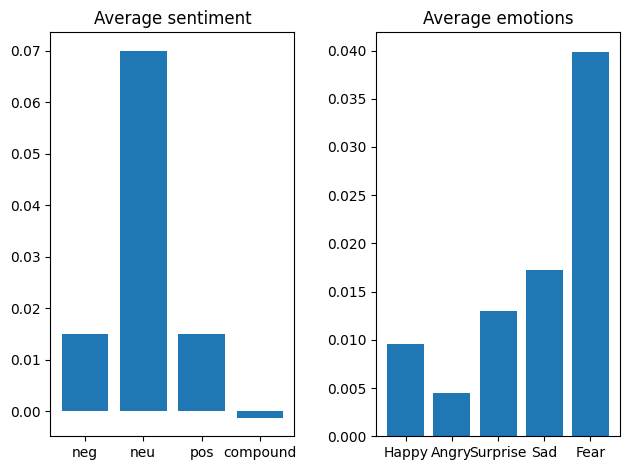

In [9]:
import matplotlib.pyplot as plt

names = list(avg_sentiment.keys())
values = list(avg_sentiment.values())
plt.subplot(1, 2, 1)
plt.title("Average sentiment")
plt.bar(range(len(avg_sentiment)), values, tick_label=names)

names = list(avg_emotions.keys())
values = list(avg_emotions.values())
plt.subplot(1, 2, 2)
plt.title("Average emotions")
plt.bar(range(len(avg_emotions)), values, tick_label=names)

plt.tight_layout(w_pad=2)
plt.show()

Dla wspólnej bazy tweetów, dominującym wskaźnikiem sentymentu jest neutralność, podczas gdy wartości pozytywne i negatywne stanowią zdecydowaną mniejszość i są rozłożone po równo.
W przypadku emocji widać zdecydowaną przewagę tych negatywnych, w szczególności strachu.

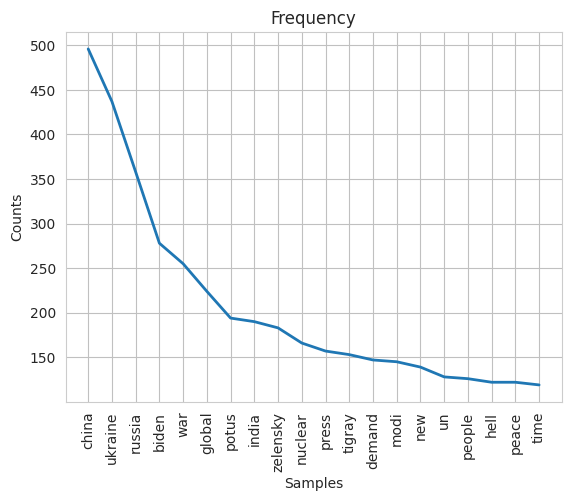

<Axes: title={'center': 'Frequency'}, xlabel='Samples', ylabel='Counts'>

In [10]:
from nltk.probability import FreqDist
import seaborn as sns

words_dist = FreqDist(topic_wide_tokens_list)
sns.set_style('whitegrid')
words_dist.plot(20,title="Frequency")

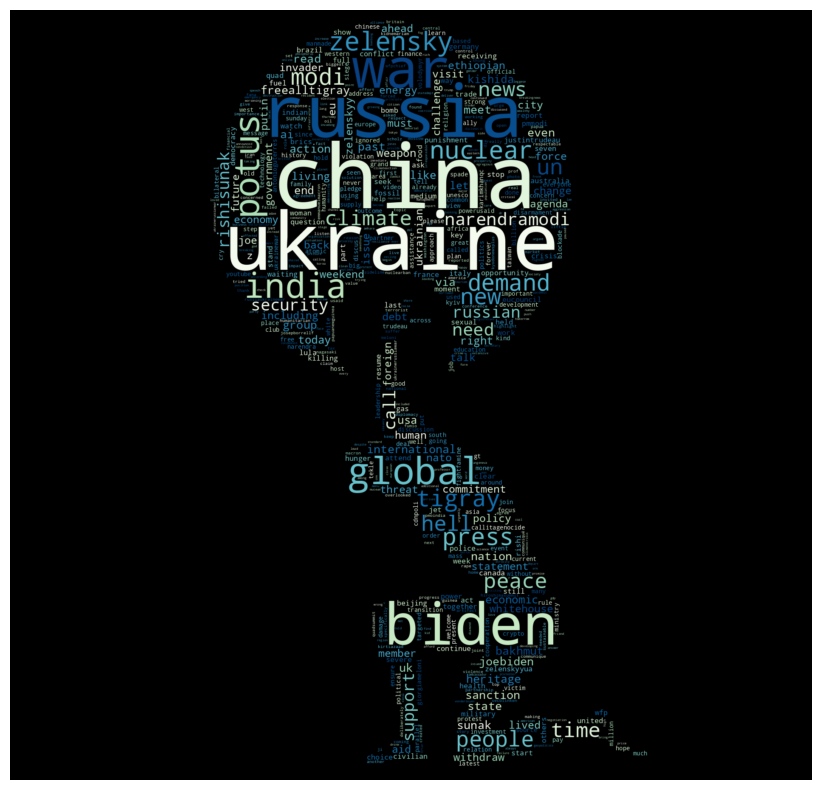

In [11]:
import numpy as np
from PIL import Image
from wordcloud import WordCloud

cloud_mask = np.array(Image.open('masks/atlas.png'))
word_cloud = WordCloud(background_color="black",mask=cloud_mask, max_words=600, colormap="GnBu").generate_from_frequencies(words_dist)
plt.figure(figsize=(20,10))
plt.clf()
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis('off')
plt.show()

W tym modelu chmura tagów znakomicie przedstawia ogół aktualnych wydarzeń politycznych.

#### Podział tweetów na podzbiory ####

In [12]:
def get_sentiment_label(sentiment):
    if sentiment["compound"] > 0 or sentiment["pos"] > sentiment["neg"]: return 1
    elif sentiment["compound"] < 0 or sentiment["pos"] < sentiment["neg"]: return -1
    else: return 0

def get_emotions_label(emotions):
    prevailing_emo = max(emotions, key=emotions.get)
    match prevailing_emo:
        case "Happy": return 4
        case "Surprise": return 3
        case "Angry": return 2
        case "Sad": return 1
        case "Fear": return 0

df_total["Sentiment label"] = df_total["Sentiment analysis"].apply(get_sentiment_label)
df_total["Emotions label"] = df_total["Emotions analysis"].apply(get_emotions_label)

df_positive = pd.DataFrame(data = df_total[df_total["Sentiment label"] == 1], columns=["Date", "Content", "Lemmatized tokens", "Sentiment analysis", "Emotions analysis"])
df_negative = pd.DataFrame(data = df_total[df_total["Sentiment label"] == -1], columns=["Date", "Content", "Lemmatized tokens", "Sentiment analysis", "Emotions analysis"])
df_neutral = pd.DataFrame(data = df_total[df_total["Sentiment label"] == 0], columns=["Date", "Content", "Lemmatized tokens", "Sentiment analysis", "Emotions analysis"])

df_happpy = pd.DataFrame(data = df_total[df_total["Emotions label"] == 4], columns=["Date", "Content", "Lemmatized tokens", "Sentiment analysis", "Emotions analysis"])
df_surprise = pd.DataFrame(data = df_total[df_total["Emotions label"] == 3], columns=["Date", "Content", "Lemmatized tokens", "Sentiment analysis", "Emotions analysis"])
df_angry = pd.DataFrame(data = df_total[df_total["Emotions label"] == 2], columns=["Date", "Content", "Lemmatized tokens", "Sentiment analysis", "Emotions analysis"])
df_sad = pd.DataFrame(data = df_total[df_total["Emotions label"] == 1], columns=["Date", "Content", "Lemmatized tokens", "Sentiment analysis", "Emotions analysis"])
df_fear = pd.DataFrame(data = df_total[df_total["Emotions label"] == 0], columns=["Date", "Content", "Lemmatized tokens", "Sentiment analysis", "Emotions analysis"])

df_list = [df_positive, df_negative, df_neutral, df_happpy, df_surprise, df_angry, df_sad, df_fear]

In [13]:
positive_tokens_list = []
negative_tokens_list = []
neutral_tokens_list = []

happy_tokens_list = []
surprise_tokens_list = []
angry_tokens_list = []
sad_tokens_list = []
fear_tokens_list = []

df_tokens_list_list = [positive_tokens_list, negative_tokens_list, neutral_tokens_list, happy_tokens_list, surprise_tokens_list, angry_tokens_list, sad_tokens_list, fear_tokens_list]
df_tokens_list_list_titles = ["Positive tweets", "Negative tweets", "Neutral tweets", "Happy tweets", "Surprise tweets", "Angry tweets", "Sad tweets", "Fear tweets"]

for df, df_tokens_list in zip(df_list, df_tokens_list_list):
    df["Lemmatized tokens"].apply(lambda tokens_list: df_tokens_list.extend(tokens_list))

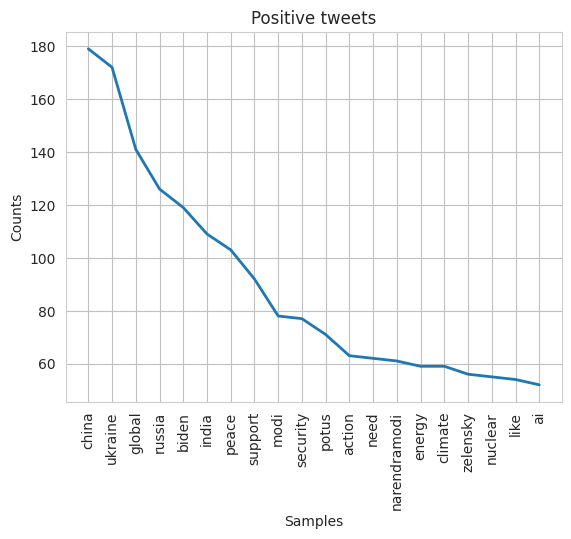

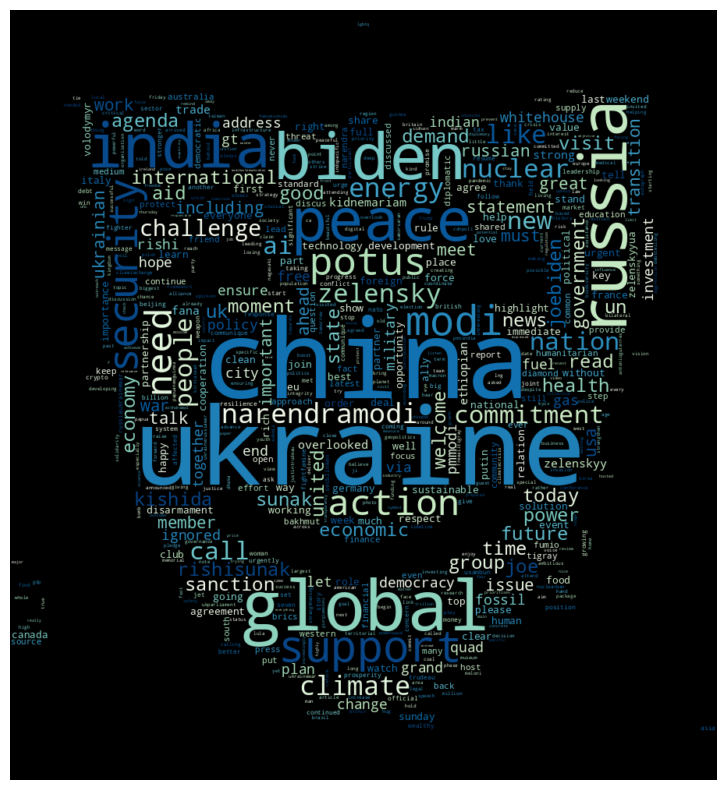

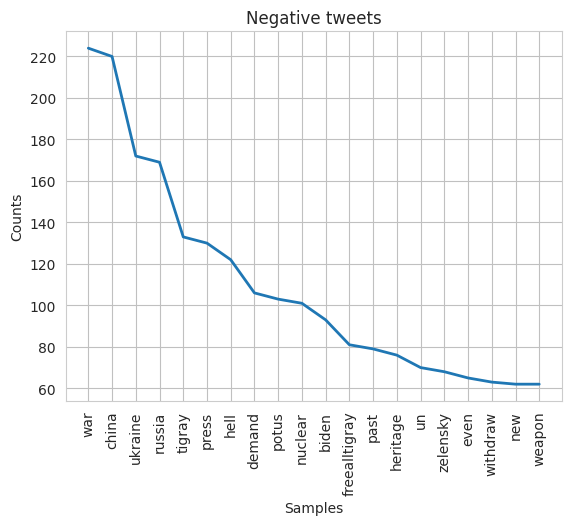

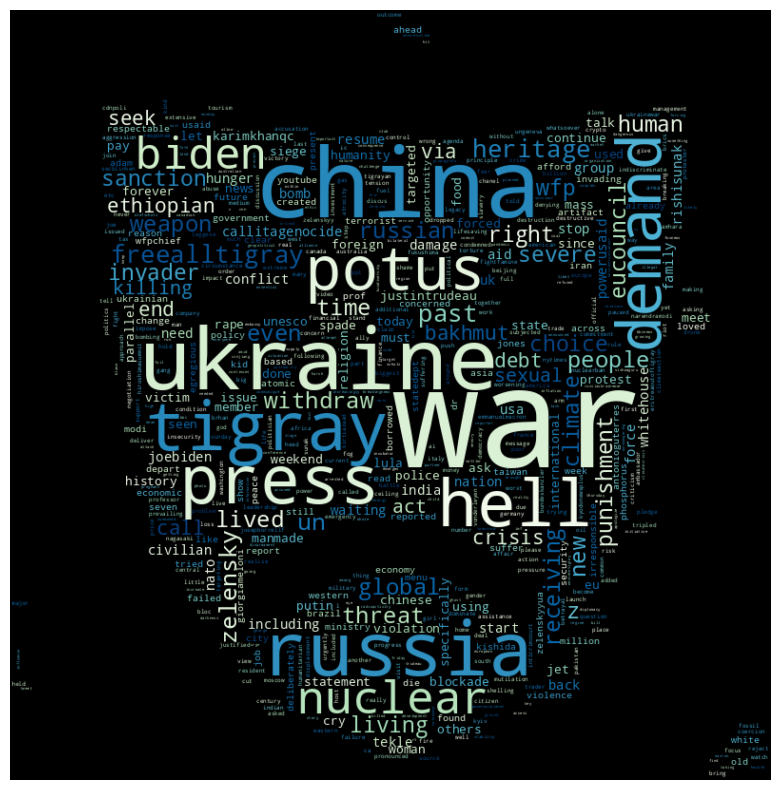

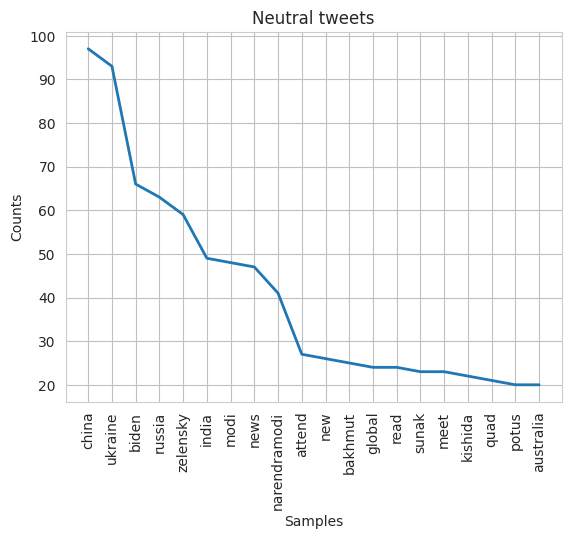

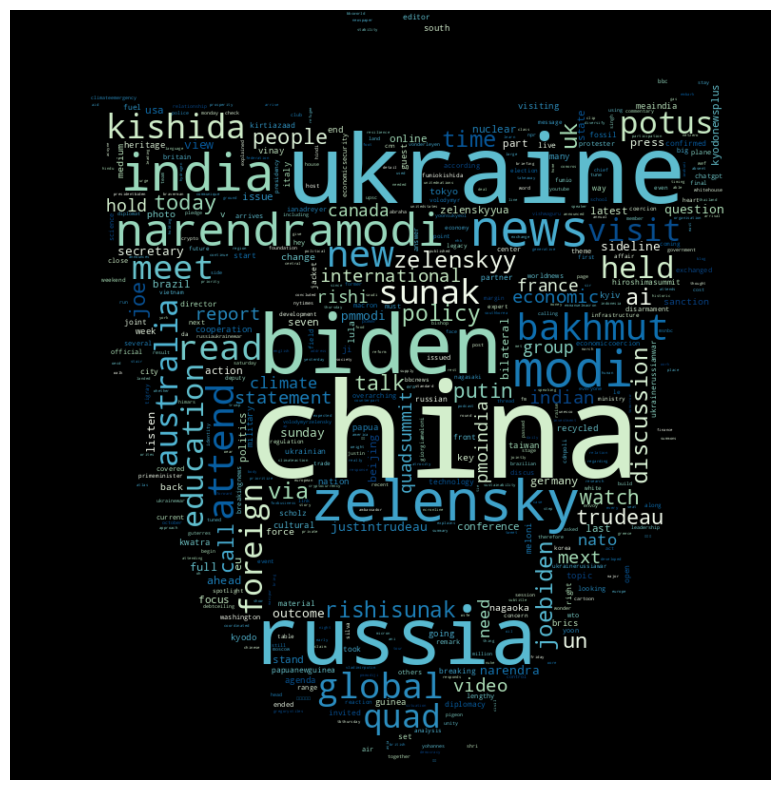

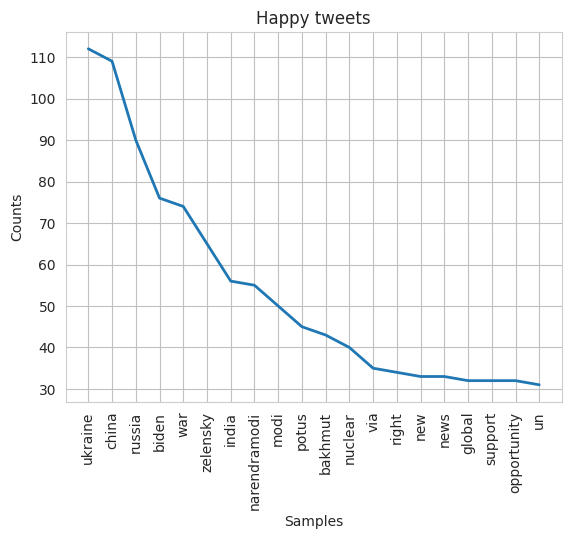

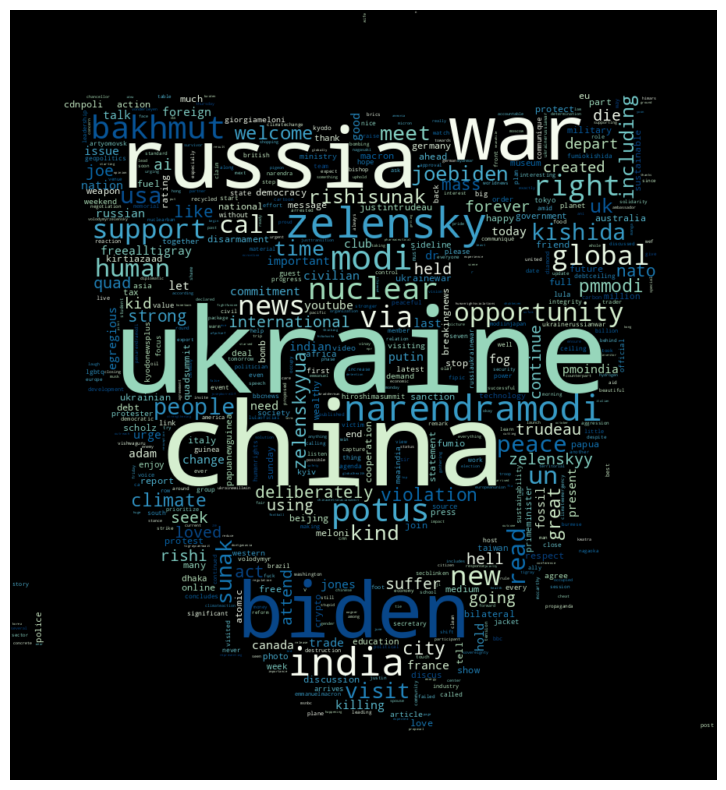

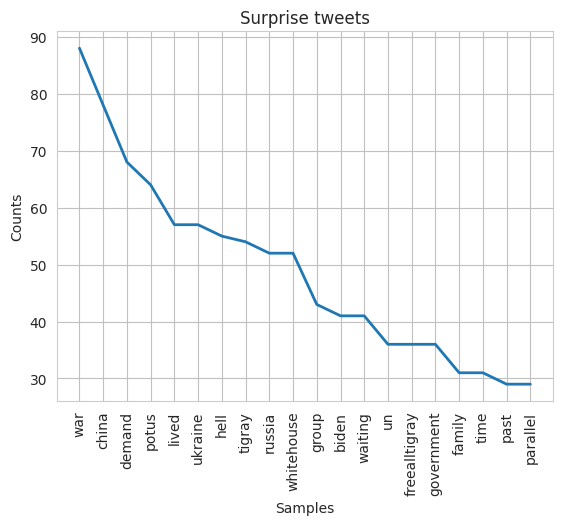

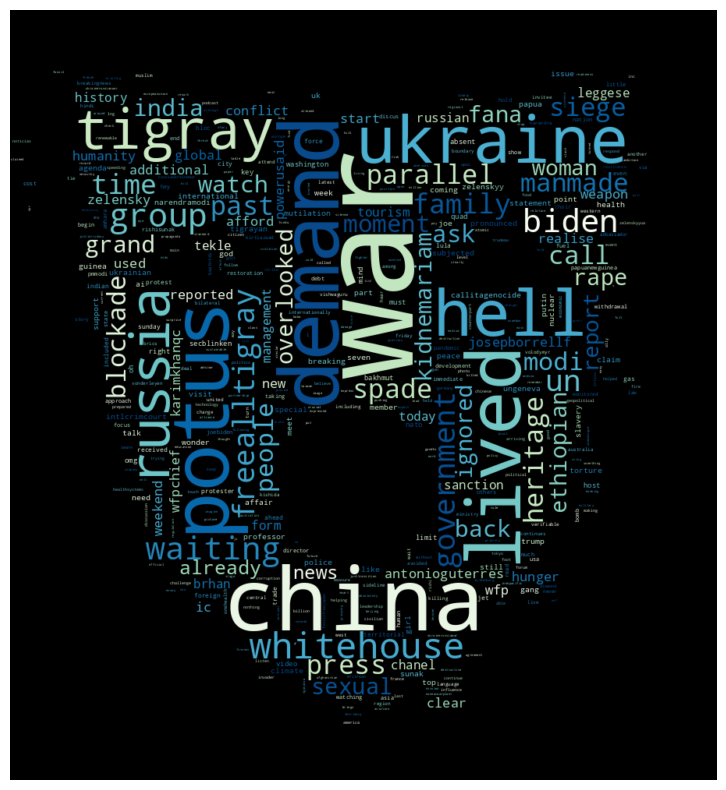

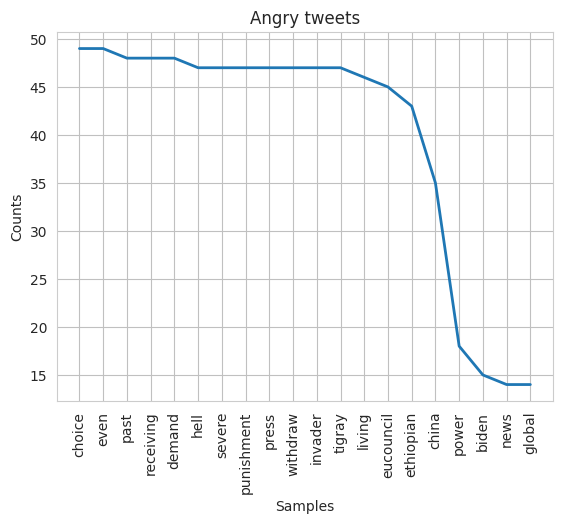

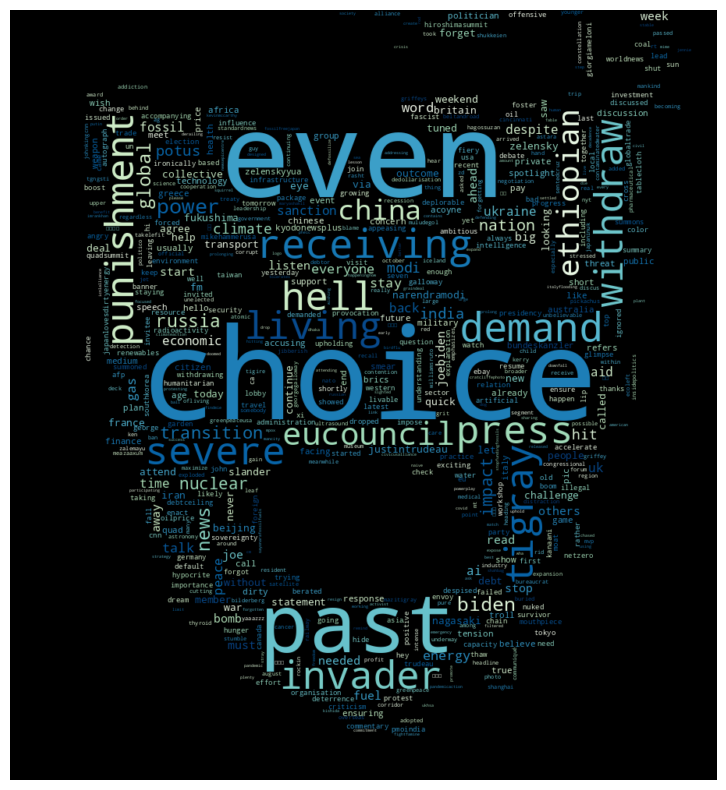

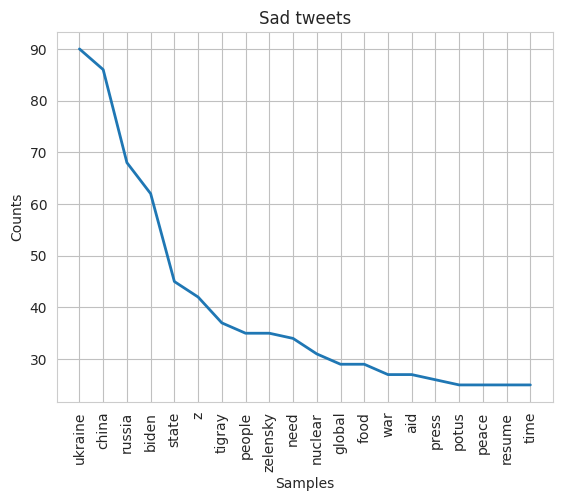

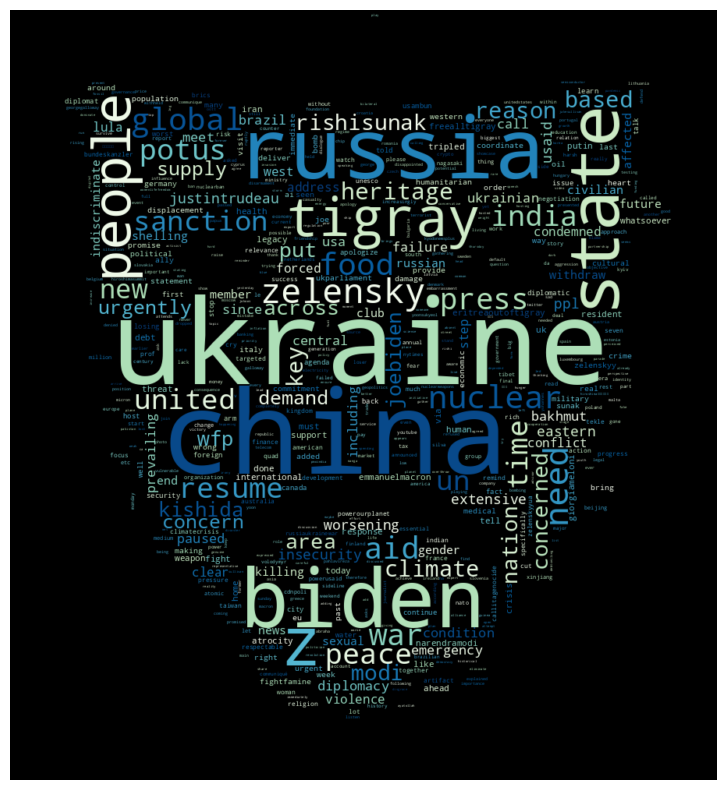

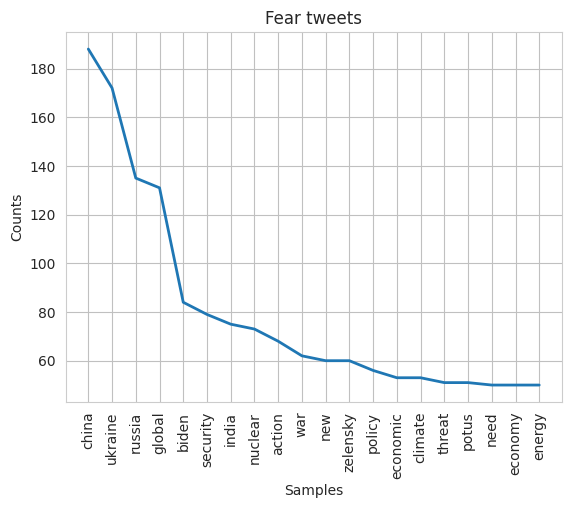

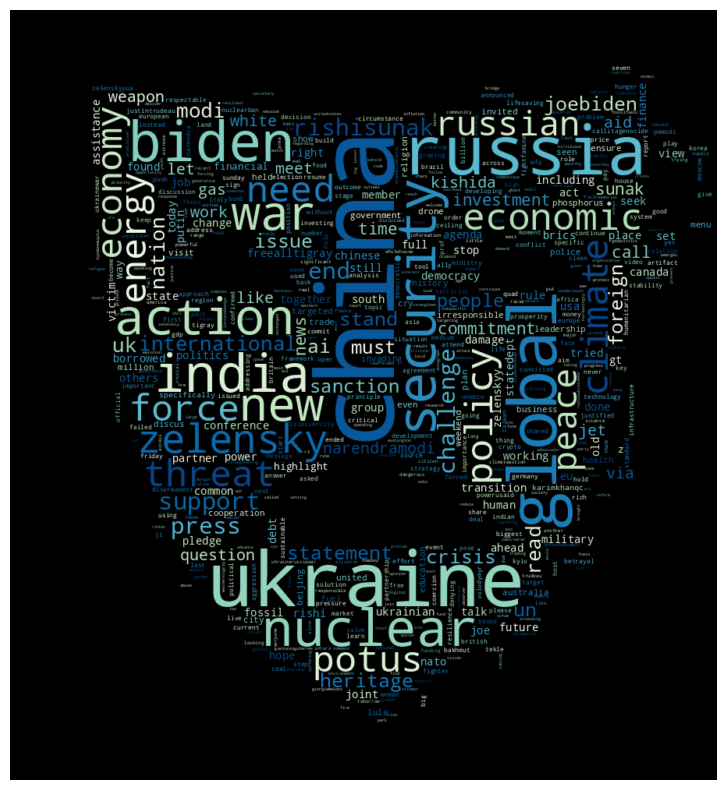

In [14]:
df_tokens_list_list_mask = ["happy.png", "neg.png", "neutral.png", "happy.png", "sup.png", "angry.png", "sad.png", "fear.png" ]

for tokens_list, title, mask in zip(df_tokens_list_list, df_tokens_list_list_titles, df_tokens_list_list_mask):
    words_dist = FreqDist(tokens_list)
    sns.set_style('whitegrid')
    words_dist.plot(20,title=f"{title}")
    cloud_mask = np.array(Image.open(f'masks/{mask}'))
    word_cloud = WordCloud(background_color="black",mask=cloud_mask, max_words=600, colormap="GnBu").generate_from_frequencies(words_dist)
    plt.figure(figsize=(10,10))
    plt.clf()
    plt.imshow(word_cloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

Przetworzone i podzielone według sentymentu i emocji tweety są dobrym źródłem dla różnorodnych, bardzo sugestywnych chmur tagów.
W szczególności, widać znaczące różnice dla kluczowych tagów (z pominięciem powtarzalnych nazw kluczowych państw, które w zależności od kontekstu można inaczej interpretować).

 - Positive: global, peace, support, commitement, need
 - Negative: war, hell, demand, press, nuclear
 - Neutral: imiona przywódców, china
 - Happy: imiona przywódców, ukraine
 - Surprise: war, demand, ukraine, hell, tigray
 - Angry: choice, even, past, punishment, invader
 - Sad: ukraine, china, russia, z, people
 - Fear: china, ukraine, russia, global, security

### Analiza czasowa ###

#### Podział na podzbiory ze względu na sentyment i emocje w danym okresie ####

In [15]:
avg_sentiment_1 = {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
avg_emotions_1 = {'Happy': 0.0, 'Angry': 0.0, 'Surprise': 0.0, 'Sad': 0.0, 'Fear': 0.0}

avg_sentiment_2 = {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
avg_emotions_2 = {'Happy': 0.0, 'Angry': 0.0, 'Surprise': 0.0, 'Sad': 0.0, 'Fear': 0.0}

avg_sentiment_3 = {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
avg_emotions_3 = {'Happy': 0.0, 'Angry': 0.0, 'Surprise': 0.0, 'Sad': 0.0, 'Fear': 0.0}

df1["Sentiment analysis"].apply(lambda sentiment: add_sentiment(avg_sentiment_1, sentiment))
df1["Emotions analysis"].apply(lambda emotions: add_emotions(avg_emotions_1, emotions))

df2["Sentiment analysis"].apply(lambda sentiment: add_sentiment(avg_sentiment_2, sentiment))
df2["Emotions analysis"].apply(lambda emotions: add_emotions(avg_emotions_2, emotions))

df3["Sentiment analysis"].apply(lambda sentiment: add_sentiment(avg_sentiment_3, sentiment))
df3["Emotions analysis"].apply(lambda emotions: add_emotions(avg_emotions_3, emotions))

calc_avg(avg_sentiment_1)
calc_avg(avg_emotions_1)

calc_avg(avg_sentiment_2)
calc_avg(avg_emotions_2)

calc_avg(avg_sentiment_3)
calc_avg(avg_emotions_3)

#### Zmiany sentymentu i emocji w czasie ####

<Axes: title={'center': 'Change of average sentiment'}, xlabel='Time period'>

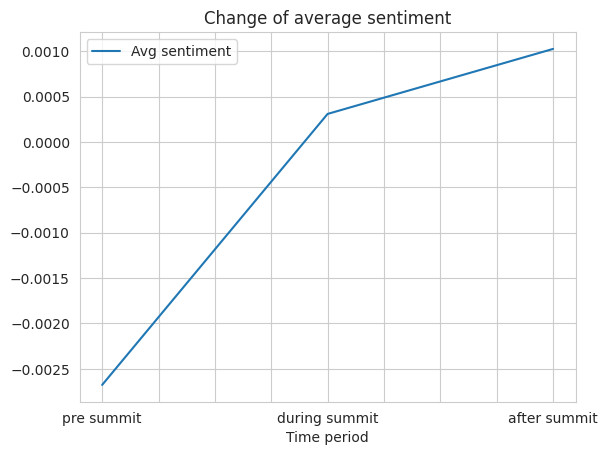

In [16]:
avg_sentiment_data=[["pre summit", avg_sentiment_1["compound"]], ["during summit", avg_sentiment_2["compound"]], ["after summit", avg_sentiment_3["compound"]]]
      
df_avg_sentiment = pd.DataFrame(avg_sentiment_data, columns=["Time period", "Avg sentiment"])
df_avg_sentiment.plot(x='Time period', title = 'Change of average sentiment')

<Axes: title={'center': 'Change of average happiness'}, xlabel='Time period'>

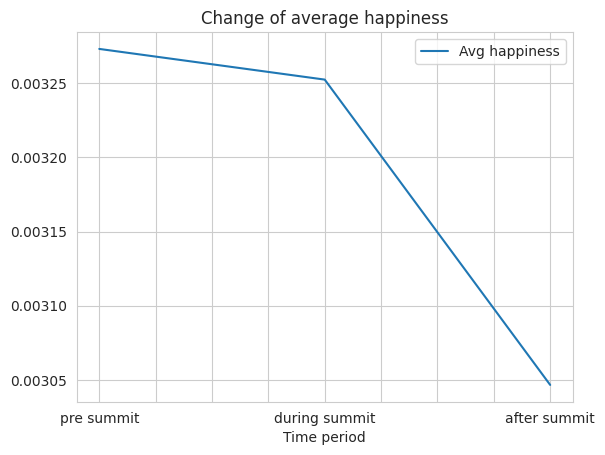

In [17]:
avg_happy_data=[["pre summit", avg_emotions_1["Happy"]], ["during summit", avg_emotions_2["Happy"]], ["after summit", avg_emotions_3["Happy"]]]
      
df_avg_happy = pd.DataFrame(avg_happy_data, columns=["Time period", "Avg happiness"])
df_avg_happy.plot(x='Time period', title = 'Change of average happiness')

<Axes: title={'center': 'Change of average surprise'}, xlabel='Time period'>

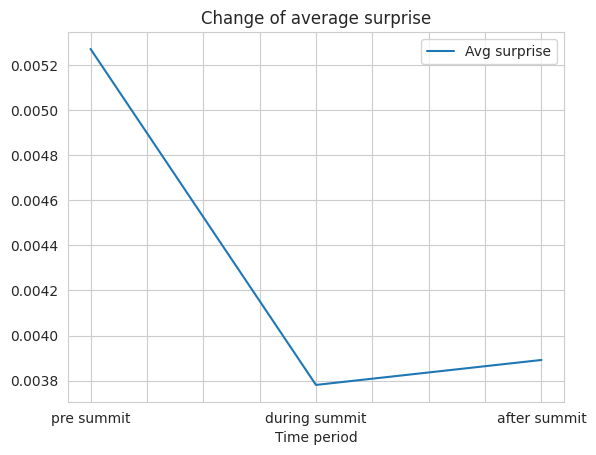

In [18]:
avg_sup_data=[["pre summit", avg_emotions_1["Surprise"]], ["during summit", avg_emotions_2["Surprise"]], ["after summit", avg_emotions_3["Surprise"]]]
      
df_avg_sup = pd.DataFrame(avg_sup_data, columns=["Time period", "Avg surprise"])
df_avg_sup.plot(x='Time period', title = 'Change of average surprise')

<Axes: title={'center': 'Change of average anger'}, xlabel='Time period'>

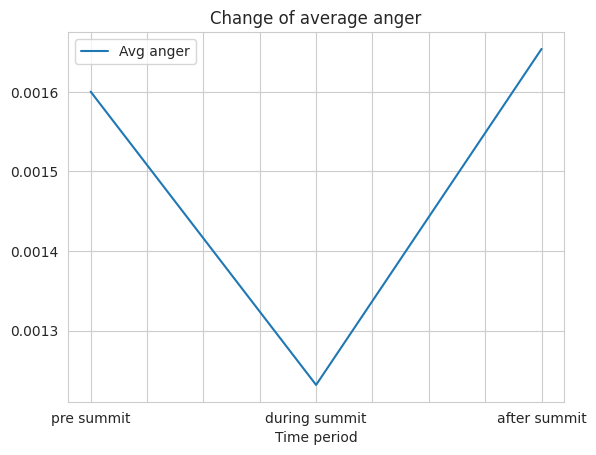

In [19]:
avg_angry_data=[["pre summit", avg_emotions_1["Angry"]], ["during summit", avg_emotions_2["Angry"]], ["after summit", avg_emotions_3["Angry"]]]
      
df_avg_angry = pd.DataFrame(avg_angry_data, columns=["Time period", "Avg anger"])
df_avg_angry.plot(x='Time period', title = 'Change of average anger')

<Axes: title={'center': 'Change of average sadness'}, xlabel='Time period'>

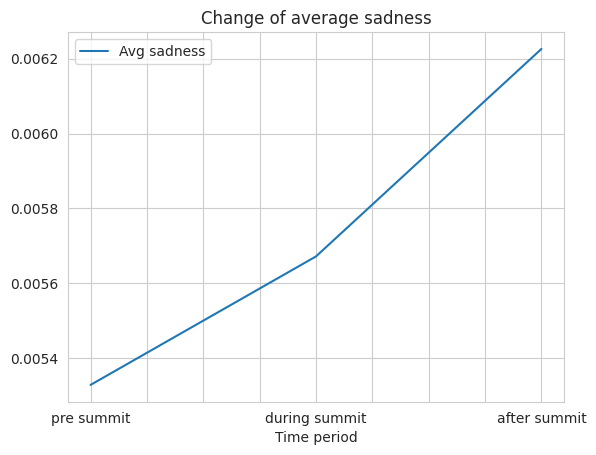

In [20]:
avg_sad_data=[["pre summit", avg_emotions_1["Sad"]], ["during summit", avg_emotions_2["Sad"]], ["after summit", avg_emotions_3["Sad"]]]
      
df_avg_sad = pd.DataFrame(avg_sad_data, columns=["Time period", "Avg sadness"])
df_avg_sad.plot(x='Time period', title = 'Change of average sadness')

<Axes: title={'center': 'Change of average fear'}, xlabel='Time period'>

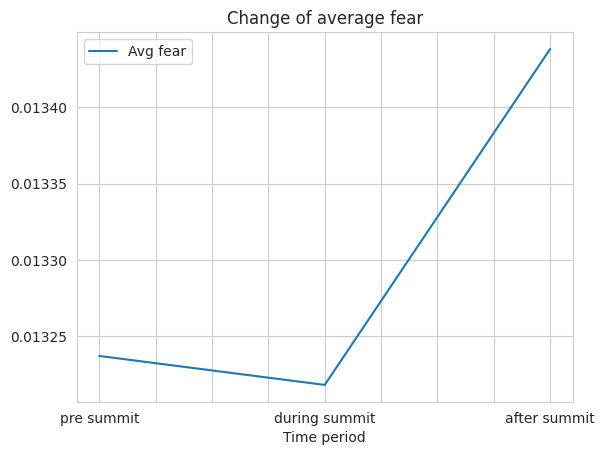

In [21]:
avg_fear_data=[["pre summit", avg_emotions_1["Fear"]], ["during summit", avg_emotions_2["Fear"]], ["after summit", avg_emotions_3["Fear"]]]
      
df_avg_fear = pd.DataFrame(avg_fear_data, columns=["Time period", "Avg fear"])
df_avg_fear.plot(x='Time period', title = 'Change of average fear')

Widać bardzo niewielki trend rosnący dla współczynnika Compound,
który z wartości negatywnej wzrósł do minimalnie pozytywnej. Happiness spadał, ze wzrostem po obradach.
Surprise, Anger i Fear odnotowały spadek do momentu obrad a następnie z powrotem wzrosły, silnie dla Anger i Fear.
Sadness rósł mniej więcej liniowo.

#### Chmury tagów dla poszególnych okresów ####

In [22]:
pre_summit_tokens_list = []
during_summit_tokens_list = []
post_summit_tokens_list = []

df_periods_tokens_list_list = [pre_summit_tokens_list, during_summit_tokens_list, post_summit_tokens_list]

for df, df_tokens_list in zip(data_frames, df_periods_tokens_list_list):
    df["Lemmatized tokens"].apply(lambda tokens_list: df_tokens_list.extend(tokens_list))

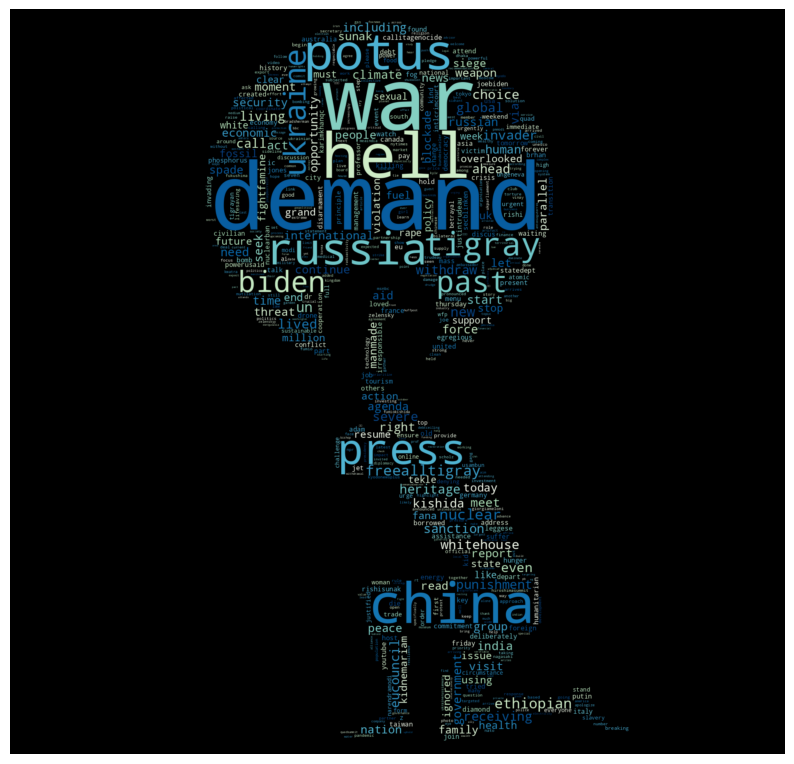

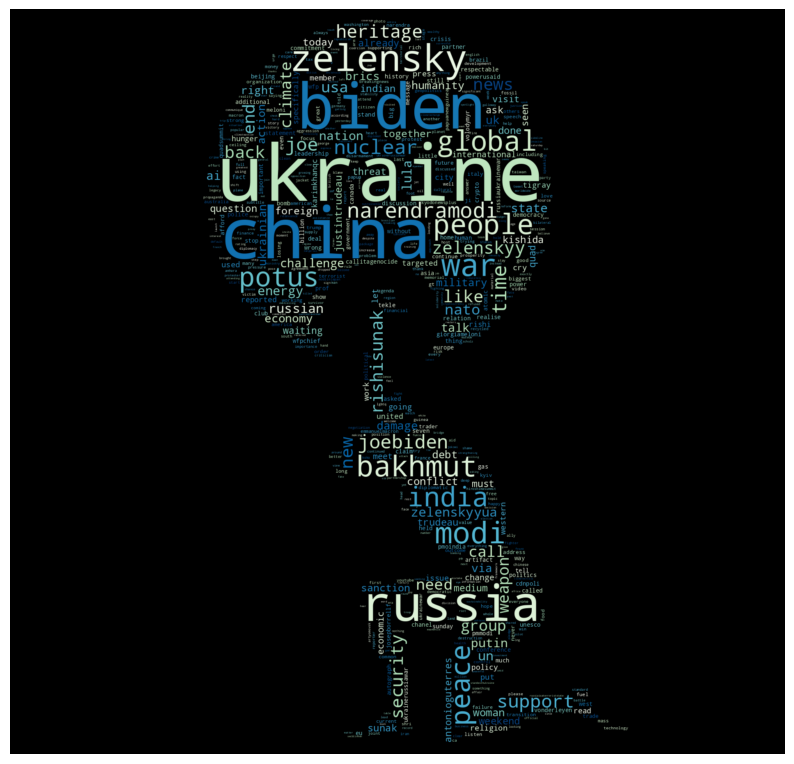

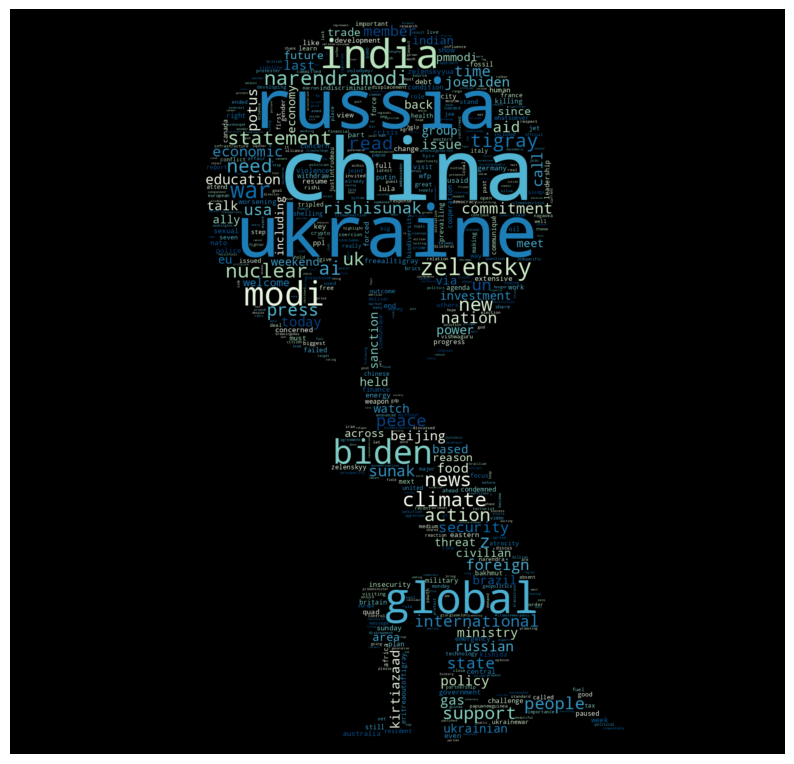

In [23]:
for tokens_list  in df_periods_tokens_list_list:
    words_dist = FreqDist(tokens_list)
    cloud_mask = np.array(Image.open('masks/atlas.png'))
    word_cloud = WordCloud(background_color="black",mask=cloud_mask, max_words=600, colormap="GnBu").generate_from_frequencies(words_dist)
    plt.figure(figsize=(10,10))
    plt.clf()
    plt.imshow(word_cloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()